# SandBox for Chest Xray Dataset Images

## Data Source


### Publication

https://arxiv.org/abs/1705.02315

### URL

https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/37178474737

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
from matplotlib import pyplot as plt
from matplotlib import cm
from warnings import warn
import os
import re
import datetime
from tqdm import tqdm

In [2]:
# set random seed
np.random.seed(42)

In [3]:
top_dir = '/home/owhitley/projects/chest_xray_8'
data_dir = os.path.join(top_dir, 'data')
image_dir = os.path.join(data_dir, 'images')
output_dir = os.path.join(top_dir, 'results')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)


In [4]:
os.listdir(data_dir)

['ChestXray_NIHCC_Download.py',
 'ChestXray_NIHCC_Download_out.txt',
 'images',
 'ChestXray_NIHCC_Download_err.txt',
 'Data_Entry_2017_v2020.csv',
 'README.txt']

# Examine Image Data

Modified code from [here](https://matplotlib.org/3.3.3/gallery/images_contours_and_fields/multi_image.html#sphx-glr-gallery-images-contours-and-fields-multi-image-py)

## Check a few typical examples

In [5]:
# number of images downloaded
len(os.listdir(image_dir))

24999

In [6]:
# example image files
ex_img_files = os.listdir(image_dir)[:5]
ex_img_files

['00006304_041.png',
 '00001498_000.png',
 '00004402_008.png',
 '00003028_069.png',
 '00001722_001.png']

In [7]:
len(ex_img_files)

5

In [8]:

def implot(imgs, rows, columns, fig_width, fig_height, channels = 1):

    
    m = 0
    if channels == 1:
        img_list = imgs
    else:
        img_list = []
        if isinstance(imgs, np.ndarray):
            n_imgs = imgs.shape[0]
        else:
            n_imgs = len(imgs)
            imgs = np.array(imgs)
            
        for i in range(n_imgs):
            for c in range(channels):
                img_list.append(imgs[i, :, :, c])
            
        rows = n_imgs
        columns = channels
        print('ignoring arguments for rows and columns')
       
    fig, axs = plt.subplots(rows, columns, figsize=(fig_width, fig_height))
    for i in range(rows):
        for j in range(columns):
            print(m)
            ex_img = img_list[m]
            if rows == 1:
                sns.heatmap(ex_img, ax = axs[j])
            elif columns == 1:
                sns.heatmap(ex_img, ax = axs[i])
            else:
                sns.heatmap(ex_img, ax = axs[i, j])
            m += 1

    plt.show()
img_list = [io.imread(os.path.join(image_dir, ex_img_files[m])) for m in range(len(ex_img_files))]    
# implot(img_list, 1, 5, 18, 3)


## Check a random sample of 1000 images for image 'shape'

Earlier I had a problem with some of the images not being 1024 x 1024 x 1, so I'm going to have to confirm that there are are in fact images with multiple 'channels' or a depth of > 1, and that this isn't some artifact happening with one of the pytorch transforms.

100%|██████████| 1000/1000 [00:12<00:00, 80.12it/s]
/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

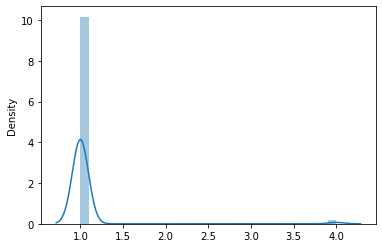

In [9]:
# check 1000 random images for having more than 1 channel

random_img_files = np.random.choice(os.listdir(image_dir), replace = False, size = 1000)
img_nc = np.repeat(-1, 3000).reshape((1000, 3))

for i in tqdm(range(1000)):
    img_i = io.imread(os.path.join(image_dir, random_img_files[i]))
    if len(img_i.shape) > 2:
        shape_i = img_i.shape
        img_nc[i] = img_i.shape
    else: 
        img_nc[i] = np.concatenate((img_i.shape, [1]))
    
    
sns.distplot(img_nc[:,2])

In [10]:
np.sum(np.greater(img_nc[:, 2], 1))

16

In [11]:
# it appears that some subset of the images has a depth of 4
img_nc[np.where(np.greater(img_nc[:, 2], 1)), :]

array([[[1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4],
        [1024, 1024,    4]]])

In [12]:
img_nc[:5,:]

array([[1024, 1024,    1],
       [1024, 1024,    1],
       [1024, 1024,    1],
       [1024, 1024,    1],
       [1024, 1024,    1]])

In [13]:
four_channel_img = np.array([io.imread(os.path.join(image_dir, x)) for x in random_img_files[np.where(np.greater(img_nc[:, 2], 1))]])

In [14]:
# Check a few examples of "four channel" images. rows are cases, columns are 'channels'
# implot(four_channel_img[:4, :, :, :], None, None, 20, 20, channels = 4)

/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='Density'>

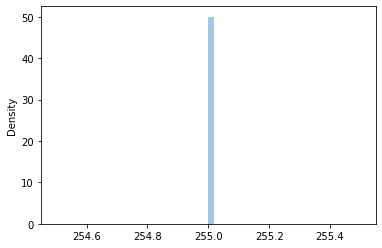

In [15]:
sns.distplot(four_channel_img[:, :, :, 3].flatten())

In [16]:
# I suspect that the first 3 channels are all identical. This turns out to be true
print(np.all(np.equal(four_channel_img[:, :, :, 0].flatten(), four_channel_img[:, :, :, 1].flatten())))
print(np.all(np.equal(four_channel_img[:, :, :, 1].flatten(), four_channel_img[:, :, :, 2].flatten())))

True
True


It appears that for some subset of the images, the image got copied 3 times, potentially into RGBA format.

## Check mean intensities of first 5 images we looked at

/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

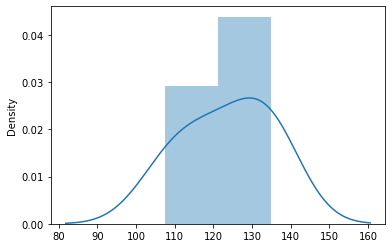

In [17]:
# check means of images
img_means = []
for i in range(len(img_list)):
    img_means.append(np.mean(img_list[i]))

sns.distplot(img_means)

In [18]:
# mean intensity
mean_intensity = np.mean(np.array(img_list))
mean_intensity

123.49591274261475

In [19]:
# std deviation
std_intensity = np.std(np.array(img_list))
std_intensity

58.199618203287606

# Define Classes/Methods for Preprocessing and Indexing Data

In [20]:
# Classes with callable methods to be used for transforms
class SampleTransform(object):
    """
    Generic Class for doing a transform of image data in a sample dict. Note that this could be extended
    to include transformations on tabular data as well, but for now we're only worried about image data
    """
    def __init__(self, img_transform):
        # img_transform must be subclass of nn.Module
        self.img_transform = img_transform
        
    def __transform__(self, sample):
        raise NotImplementedError('method __transform__ not defined for this class.')
    
    def __call__(self, sample):
        image, table_data = sample['image'], sample['table_data']
        transf_image = self.__transform__(image)
        sample_return = {'image': transf_image, 'table_data': table_data}
        return sample_return
        
class ToTensor(SampleTransform):
    """
    Turns image into a pytorch tensor. See docs for
    torchvision.transforms.ToTensor() for more details
    """
    def __init__(self):
        super().__init__(img_transform = transforms.ToTensor())
        
    def __transform__(self, image):
        transf_image = self.img_transform.__call__(image)
        return transf_image
    
class TorchMean(SampleTransform):
    """
    """
    
class Normalize(SampleTransform):
    """
    Normalize an image to specified mean and std deviation
    """
    def __init__(self, mean, std, inplace = False):
        super().__init__(img_transform = transforms.Normalize(mean, std, inplace))
        
    def __transform__(self, image):
        transf_image = self.img_transform.__call__(image)
        return transf_image

class RandomHorizontalFlip(SampleTransform):
    """
    Performs random horizontal flip of image with p = 0.5 for the flip
    See docs for torchvision.transforms.RandomHorizontalFlip for more details
    """
    def __init__(self):
        super().__init__(img_transform = transforms.RandomHorizontalFlip())
        
    def __transform__(self, image):
        transf_image = self.img_transform.__call__(image)
        return transf_image

In [21]:
basic_transform = transforms.Compose([
        ToTensor(),
        Normalize(mean_intensity, std_intensity),
        RandomHorizontalFlip()
    ])

In [22]:
class XRayDataset(Dataset):
    """
    Xray images dataset. Inspired in part by: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    Used to manage indexing of tabular and image data, as well as do limited transformations of tabular data
    """
    
    def __init__(self, table_data, root_dir, transform=None):
        """
        Args:
            csv (string): Path to the csv file with tabular data corresponding to images, or pandas dataframe
            root_dir (string): Directory with all the images. Assumes all images in 1 directory, (no subdirectories)
            transform (callable, optional): Optional transform to be applied
                on a sample.
        Notes:
            csv file is read, and then listed images checked against those actually present in root_dir
            only images in the intersection of images listed in csv file and images present in root_dir
            will be used in the XRayDataSet object. Also, transforms could range from initial preprocessing
            for images to be used in training autoencoder to running images through preprocessing and 
            
        """
        
        if isinstance(table_data, str):
            table_data = pd.read_csv(table_data)
        else:
            try:
                assert isinstance(table_data, pd.DataFrame)
            except:
                raise TypeError('table_data must be valid filepath or pandas DataFrame')
                
        self.table_data = table_data
        self.root_dir = root_dir
        
        # subset tabular data only for images in intersection of tabular data and images present in root_dir
        tab_images = self.table_data['Image Index'].to_numpy().astype('str')
        dir_images = os.listdir(root_dir)
        common_images = np.intersect1d(tab_images, dir_images)
        msg = "{0} images common to root_dir ({1} images) and table data ({2} images)"
        print(msg.format(len(common_images), len(dir_images), len(tab_images)))
        
        if len(common_images) < 1:
            raise ValueError('0 images common between root_dir and table data')
        
        idx_keep = np.in1d(tab_images, common_images)
        self.table_data = self.table_data.iloc[idx_keep, :]
        
        self.transform = transform
        
    def __len__(self):
        return(len(self.table_data))
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.table_data.iloc[idx, 0])
        image = io.imread(img_name)
        if len(image.shape) > 2:
            # assuming that first image in image series identical to 2 others in series,
            # and last (4th) is blank as was seen in earlier exploration of 'multi-channel'
            # images.
            image = image[:, :, 0]
        # gets 1 row of dataframe if idx of len 1 and returns it as a dict
        table_data = self.table_data.iloc[np.arange(0,1), :].to_dict(orient = 'records')[0]['Image Index']
        
        sample = {'image': image, 'table_data': table_data}

        if self.transform:
            sample = self.transform(sample)

        return sample
        
    def get_label_names(self, col):
        """
        get unique label names. assume multilabel entries are separated
        by a pipe character
        """
        # get unique label names
        col_contents = self.table_data[col]
        label_names = [re.split('\|', x) for x in col_contents.to_numpy().astype('str')]
        label_names = np.unique(np.array([x for y in label_names for x in y]))
        return label_names
        
    def one_hot(self, col, label):
        """
        One-hot encode a particular label in categorical data. 
        """
        r = re.compile('(\|)*' + label + '(\|)*')
        col_content = self.table_data[col].to_numpy().astype('str')
        vmatch = np.vectorize(lambda x:bool(r.search(x)))
        sel = vmatch(col_content).astype('int32')
        new_col = label
        if new_col in self.table_data.keys():
            warn(new_col + ' is already present in dataframe, replacing')
        self.table_data[new_col] = sel
        
    def one_hot_all_labels(self, col):
        """
        One hot encode all unique labels in a column. Assume that multilabel entries are
        separated by a pipe | character
        """
        all_labels = self.get_label_names(col)
        for label in all_labels:
            self.one_hot(col, label)
            
    def get_multi_label(self, col):
        """
        """
        r = re.compile('\|')
        col_content = self.table_data[col].to_numpy().astype('str')
        vmatch = np.vectorize(lambda x:bool(r.search(x)))
        sel = vmatch(col_content).astype('int32')
        new_col = col + '_IsMultiLabel'
        if new_col in self.table_data.keys():
            warn(new_col + ' is already present in dataframe, replacing')
        self.table_data[new_col] = sel
        
        
    def train_test_split(self, stratify = None, train_frac = 0.8):
        """
        Args:
            stratify = str
        return: a dict of 2 XRayDataset class objects referring to the same image directory
        """
            
        if isinstance(stratify, str):
            stratify = self.table_data[stratify].to_numpy() 
        
        
        # get split indices
        n_total = self.__len__()
        all_inds = np.arange(n_total)
        train_inds, test_inds = train_test_split(all_inds, train_size = train_frac, stratify = stratify)
        train_table = self.table_data.iloc[train_inds, :]
        test_table = self.table_data.iloc[test_inds, :]
        n_train = len(train_inds)
        n_test = len(test_inds)
        print("No. Train:{} No. Test:{}".format(n_train, n_test))
        # make and return datasets
        TrainDS = XRayDataset(train_table, self.root_dir, self.transform)
        TestDS = XRayDataset(test_table, self.root_dir, self.transform)
        dict_return = {'train': TrainDS, 'test': TestDS}
        return dict_return
        
        

In [23]:
# For now take first 5000 images from table data
table_data = pd.read_csv(os.path.join(data_dir, 'Data_Entry_2017_v2020.csv'))
table_data = table_data.iloc[0:500, :]
VAE_DS = XRayDataset(table_data = table_data, 
                     root_dir = image_dir, transform = basic_transform)

500 images common to root_dir (24999 images) and table data (500 images)


In [24]:
# # check that data transform works
# proc_img_list = [VAE_DS[i]['image'].numpy()[0, :, :] for i in range(5)]

In [25]:
# implot(proc_img_list, 1, 5, 18, 3)

In [26]:
# sns.distplot(np.array(proc_img_list[0]).flatten())

In [27]:
print(type(VAE_DS[0]))

<class 'dict'>


# Define Model

For now we start out with a relatively simple architecture for encoder + decoder. If we really want to get fancy can consider resnet or inception layers, but for now let's get a simple first pass done. Code in large part borrowed from https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb.

For the most part it appears that pixel intensity follows a distribution of a mixture of gaussians, so for now it might be best to use gaussian $log p(x|z) $ instead of bernoulli equivalent (i.e. binary cross entropy)

In [28]:
def conv_output_size(W1, S, F, P):
    """
    W1 = input width
    S = Stride
    F = Filter (kernel) size
    P = padding
    returns: W2, or output width
    """
    W2 = np.floor((W1 + 2*P - F)/S) + 1
    return W2
    
class Encoder(nn.Module):
    """
    Encoder function. Assumes square image input with 1 channel.
    """
    def __init__(self, c, input_size = 1024, latent_dims = 20, S = 2, F = 4, P = 1):
        super(Encoder, self).__init__()
        # note: if we want to make this prettier later we can make depth a controllable parameter
        # and loop over depth indices to produce layers or call layers when running the forward method
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=F, stride=S, padding=P) 
        conv1_out_size = conv_output_size(input_size, S, F, P)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=F, stride=S, padding=P)
        conv2_out_size = conv_output_size(conv1_out_size, S, F, P)
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=F, stride=S, padding=P)
        conv3_out_size = conv_output_size(conv2_out_size, S, F, P)
        linear_input_size = (int(c*4*conv3_out_size*conv3_out_size))
        self.fc_mu = nn.Linear(in_features=linear_input_size, out_features=(int(latent_dims)))
        self.fc_logvar = nn.Linear(in_features=linear_input_size, out_features=(int(latent_dims)))
            
    def forward(self, x):
        x = F.softplus(self.conv1(x))
        x = F.softplus(self.conv2(x))
        x = F.softplus(self.conv3(x))
        x = x.view(x.size((int(0))), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar 

    
class Decoder(nn.Module):
    def __init__(self, c, input_size = 1024, latent_dims = 20, S = 2, F = 4, P = 1):
        super(Decoder, self).__init__()
        # the below four lines are ugly but quick. In future make this class able to dynamically
        # allocate layers, but first let's get a simple first pass
        conv1_out_size = conv_output_size(input_size, S, F, P)
        conv2_out_size = conv_output_size(conv1_out_size, S, F, P)
        conv3_out_size = conv_output_size(conv2_out_size, S, F, P)
        self.conv3_out_size = int(conv3_out_size)
        self.channels = c
        self.fc1 = nn.Linear(in_features=(int(latent_dims)), out_features=(int(c*4*conv3_out_size*conv3_out_size)))
        self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=F, stride=S, padding=P)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=F, stride=S, padding=P)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=F, stride=S, padding=P)
            
    def forward(self, x):
        c = self.channels
        conv3_out_size = self.conv3_out_size
        x = self.fc1(x)
        x = x.view((x.shape[0], c*4, conv3_out_size, conv3_out_size)) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.softplus(self.conv3(x))
        x = F.softplus(self.conv2(x))
        x = self.conv1(x)
        return x
    
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size = 1024, c = 4, latent_dims = 20, S = 2, F = 4, P = 1, training = True):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(input_size = input_size, c = c, latent_dims = latent_dims, S = S, F = F, P = P)
        self.decoder = Decoder(input_size = input_size, c = c, latent_dims = latent_dims, S = S, F = F, P = P)
        self.training = training
        
    def set_train_status(self, training):
        self.training = training
        
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        z = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(z)
        return x_recon, z, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            # std deviation = sqrt(var) or exp(1/2 logvar) 
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            z = eps.mul(std).add_(mu) 
        else:
            # It appears that when not training, you want to return the 'expected' position
            z = mu
            
        return z


    
def vae_loss(recon_x, x, z, mu, logvar):
    """
    recon_x = reconstructed images of x
    x = original set of images
    mu = mean
    logvar = log-variance
    """
    std_pixels = torch.std(x)
    # calculate log p(x|z) for all pixels. calculated over all pixels over all images
    # normal_dist = torch.distributions.normal.Normal(0, 1)
    # std_norm_xz = (recon_x - x)/std_pixels
    normal_xz = torch.distributions.normal.Normal(recon_x, std_pixels)
    log_pxz = torch.sum(normal_xz.log_prob(x))
    # calculate log p(z). calculated over all images over all latent dims
    normal_z = torch.distributions.normal.Normal(0., 1.)
    log_pz = torch.sum(normal_z.log_prob(z))
    # calculate log q(z). calculated over all images over all latent dims
    #std_norm_zx = (z-mu)/(logvar.exp())
    normal_zx = torch.distributions.normal.Normal(mu, torch.exp(logvar))
    log_qz = torch.sum(normal_zx.log_prob(z))
    
    total_samples = np.float(recon_x.shape[0])
    # using this sum is same as performping log p(x|z) + log p(z) - log q(z)
    # for all images, and then summing over all images.
    summed_elbo = log_pxz + log_pz - log_qz
    # ELBO = Eq[log p(x|z) + log p(z) - log q(z)]
    elbo = summed_elbo/total_samples
    # we want to maximize elbo so we set the -elbo as the loss
    loss = -elbo
    return loss, elbo, log_pxz
        


In [29]:
# double check expected output size for convolution 3 and input size for encoder linear layer
conv_output_size(1024, 2, 4, 1)

512.0

In [30]:
conv_output_size(512, 2, 4, 1)

256.0

In [31]:
conv_output_size(256, 2, 4, 1)


128.0

In [32]:
128*128*4*4

262144

# Define Classes/Functions to Be Used for Training and Evaluation

In [33]:
class Trainer(object):
    
    def __init__(self, XRayDS, stratify = None, train_frac = 0.8):
        # below lines commonted out as I can't figure out whey isinstance(XRayDS, XRayDataset) fails
#         try:
#             assert isinstance(XRayDS, XRayDataset)
#         except:
#             raise TypeError('XRayDS must be instance of XRayDataset')
        self.SplitData = XRayDS.train_test_split(stratify, train_frac)
        self.VAE = VariationalAutoencoder()
        self.optimizer = torch.optim.Adam(self.VAE.parameters(), lr=1e-5, weight_decay=1e-6)
        self.running_stats = None
    
    def train(self, num_epochs = 2, batch_size = 100):
        # DataLoaders go through all complete batches
        train_loader = DataLoader(self.SplitData['train'], batch_size=batch_size,
                                  shuffle=True, num_workers=0, drop_last = True)
        test_loader = DataLoader(self.SplitData['test'], batch_size=batch_size,
                                 shuffle=True, num_workers=0, drop_last = True)
        loaders = {'train': train_loader, 'test': test_loader}
        running_stats = {'train': {'avg_elbo': np.array([]), 'avg_log_pxz': np.array([])},
                        'test': {'avg_elbo': np.array([]), 'avg_log_pxz': np.array([])}}
        for epoch in range(num_epochs + 1):
            print('===========================================')
            avg_loss = {'train': None, 'test': None}
            now = datetime.datetime.now()
            print(now.strftime("%Y-%m-%d %H:%M:%S"))
            if epoch == num_epochs:
                print('Final Results')
                do_backprop = False
            else:
                print('Epoch {} / {}'.format(epoch+1, num_epochs))
                do_backprop = True
                
            for stage in ['train', 'test']:
                print('__' + stage + '__')
                now = datetime.datetime.now()
                print('Stage Beginning')
                print(now.strftime("%Y-%m-%d %H:%M:%S"))
                if stage == 'train':
                    self.VAE.set_train_status(True)
                else:
                    self.VAE.set_train_status(False)
                
                DS = self.SplitData[stage]
                total_elbo = 0.
                total_log_pxz = 0.
                m = 0
                for sample_batched in loaders[stage]:
                    x = sample_batched['image']
                    recon_x, z, mu, logvar = self.VAE.forward(x)
                    loss, elbo, log_pxz = vae_loss(recon_x, x, z, mu, logvar)
                    total_elbo += elbo
                    total_log_pxz += log_pxz
                    if do_backprop:
                        if stage == 'train':
                            self.optimizer.zero_grad()
                            loss.backward()
                            self.optimizer.step()
                        
                    m += 1
                # average ELBO across batches + log p(x|z)
                # since log p(x|z) is summed across all pixels across all samples,
                # the sum across all batches is the joint probability across all batches.
                # dividing total_log_pxz by the number of batches gets a log geometric mean
                # for p(x|z) across batches
                avg_elbo = total_elbo/np.float(m)
                avg_log_pxz = total_log_pxz/np.float(m)
                
                now = datetime.datetime.now()
                print('Stage Finished')
                print(now.strftime("%Y-%m-%d %H:%M:%S"))
                print('ELBO (avg): {:.2e} log p(x|z): (avg) {:.2e} '.format(avg_elbo, avg_log_pxz))
                running_stats[stage]['avg_elbo'] = np.append(running_stats[stage]['avg_elbo'], avg_elbo.detach().numpy())
                running_stats[stage]['avg_log_pxz'] = np.append(running_stats[stage]['avg_log_pxz'], avg_log_pxz.detach().numpy())
                
        self.running_stats = running_stats
        print('===========================================')
        print('Finished!')
        now = datetime.datetime.now()
        print(now.strftime("%Y-%m-%d %H:%M:%S"))
        
                

# Exploration of Tabular Data

We explore the distribution of Finding Labels and other image related tabular data, such as patient age, patient ID, and patient gender

In [34]:
total_images = VAE_DS.__len__()
total_images

500

In [35]:
VAE_DS.table_data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
495,00000118_001.png,Atelectasis|Emphysema,1,118,73,M,PA,2990,2991,0.143,0.143
496,00000118_002.png,Emphysema|Pneumothorax,2,118,73,M,PA,2992,2991,0.143,0.143
497,00000118_003.png,Atelectasis|Emphysema|Pneumothorax,3,118,73,M,PA,2992,2991,0.143,0.143
498,00000118_004.png,Emphysema|Pneumothorax,4,118,73,M,PA,2992,2991,0.143,0.143


In [36]:
VAE_DS.one_hot_all_labels('Finding Labels')

In [37]:
VAE_DS.table_data.loc[:, VAE_DS.get_label_names('Finding Labels')]

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
497,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
498,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [38]:
VAE_DS.get_multi_label('Finding Labels')

In [39]:
# check distribution of Finding Labels. 
label_names = np.concatenate((VAE_DS.get_label_names('Finding Labels'), np.array(['Finding Labels_IsMultiLabel'])))
for lab in label_names:
    print("{}: {}".format(lab, np.sum(VAE_DS.table_data[lab].to_numpy())))

Atelectasis: 57
Cardiomegaly: 57
Consolidation: 26
Edema: 24
Effusion: 119
Emphysema: 33
Fibrosis: 14
Hernia: 9
Infiltration: 100
Mass: 33
No Finding: 172
Nodule: 20
Pleural_Thickening: 15
Pneumonia: 5
Pneumothorax: 37
Finding Labels_IsMultiLabel: 147


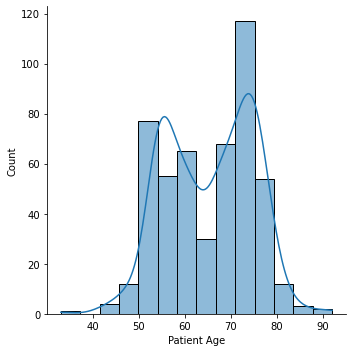

In [40]:
# Check Distribution of Ages
sns.displot(VAE_DS.table_data['Patient Age'], kde = True)

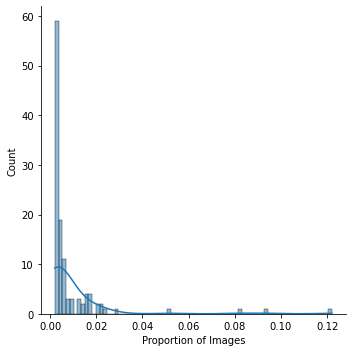

In [41]:
# check proportion of images accounted for by each patient.
# It turns out that a small proportion of patients each account for 5 in every 1000 images or so.
# Still, this isn't horrifyinglying biased towards any individual patient
g = sns.displot(VAE_DS.table_data['Patient ID'].value_counts()/np.float(total_images), kde = True)
g.set_axis_labels("Proportion of Images", "Count")

In [42]:
# Check Male/Female Distribution
VAE_DS.table_data['Patient Gender'].value_counts()

F    266
M    234
Name: Patient Gender, dtype: int64

<AxesSubplot:xlabel='Patient Gender', ylabel='Patient Age'>

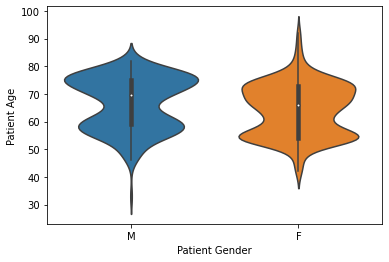

In [43]:
# Check Distribution of ages among genders
sns.violinplot(data = VAE_DS.table_data, x = 'Patient Gender', y = 'Patient Age')

# Train the Model!

In [44]:
VAE_Trainer = Trainer(XRayDS = VAE_DS)

No. Train:400 No. Test:100
400 images common to root_dir (24999 images) and table data (400 images)
100 images common to root_dir (24999 images) and table data (100 images)


/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [45]:
n_epochs = 20
VAE_Trainer.train(num_epochs = n_epochs, batch_size = 100)

2021-01-08 00:01:29
Epoch 1 / 20
__train__
Stage Beginning
2021-01-08 00:01:29
Stage Finished
2021-01-08 00:02:14
ELBO (avg): -1.02e+11 log p(x|z): (avg) -1.02e+13 
__test__
Stage Beginning
2021-01-08 00:02:14
Stage Finished
2021-01-08 00:02:20
ELBO (avg): -1.05e+11 log p(x|z): (avg) -1.05e+13 
2021-01-08 00:02:20
Epoch 2 / 20
__train__
Stage Beginning
2021-01-08 00:02:20
Stage Finished
2021-01-08 00:03:05
ELBO (avg): -1.00e+11 log p(x|z): (avg) -1.00e+13 
__test__
Stage Beginning
2021-01-08 00:03:05
Stage Finished
2021-01-08 00:03:11
ELBO (avg): -1.04e+11 log p(x|z): (avg) -1.04e+13 
2021-01-08 00:03:11
Epoch 3 / 20
__train__
Stage Beginning
2021-01-08 00:03:11
Stage Finished
2021-01-08 00:03:56
ELBO (avg): -1.00e+11 log p(x|z): (avg) -1.00e+13 
__test__
Stage Beginning
2021-01-08 00:03:56
Stage Finished
2021-01-08 00:04:02
ELBO (avg): -1.04e+11 log p(x|z): (avg) -1.04e+13 
2021-01-08 00:04:02
Epoch 4 / 20
__train__
Stage Beginning
2021-01-08 00:04:02
Stage Finished
2021-01-08 00:04:4

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-aa47bc0a6ef5>", line 2, in <module>
    VAE_Trainer.train(num_epochs = n_epochs, batch_size = 100)
  File "<ipython-input-33-fd033a7c3c43>", line 58, in train
    loss.backward()
  File "/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/torch/tensor.py", line 185, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/torch/autograd/__init__.py", line 127, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/IPyt

TypeError: object of type 'NoneType' has no len()

In [ ]:
# plt.plot(np.arange(n_epochs + 1) + 1, VAE_Trainer.running_stats['train']['avg_elbo'], label = 'train')
# plt.plot(np.arange(n_epochs + 1) + 1, VAE_Trainer.running_stats['test']['avg_elbo'], label = 'test')
# plt.xlabel('epochs')
# plt.ylabel('elbo')
# plt.legend()
# plt.show()

In [ ]:
# VAE_Trainer.running_stats['train']['avg_elbo']

In [ ]:
# VAE_Trainer.running_stats['test']['avg_elbo']

In [ ]:
# train_loader = DataLoader(VAE_Trainer.SplitData['train'], batch_size=100,
#                                   shuffle=True, num_workers=0, drop_last = True)

In [ ]:
# batch = next(iter(train_loader))

In [ ]:
# batch['image'].shape

In [ ]:
# for batch in train_loader:
#     print(batch['image'].shape)

In [ ]:
# check output
result = VAE_Trainer.VAE.forward(batch['image'])

In [ ]:
# result[0]

In [ ]:
# result[1].shape

In [ ]:
# result[2].shape

In [ ]:
# result[3].shape

In [ ]:
# recon_x, z, mu, logvar = VAE_Trainer.VAE.forward(batch['image'])

In [ ]:
for p in VAE_Trainer.VAE.parameters():
    print(p)

In [ ]:
VAE_Trainer.VAE.parameters()

In [ ]:
VAE = VAE_Trainer.VAE
torch.save(VAE.state_dict(), path = os.path.join(output_dir, 'VAE_state_dict_trained.pt'))